# Poker Agent V13: Enhanced Architecture

**Key Improvements over V12:**
1. **Dueling DQN**: Separate value and advantage streams for better learning
2. **Prioritized Experience Replay**: Sample important transitions more often
3. **6 Bet Sizing Actions**: Fold, Call, Small/Med/Large Raise, All-In
4. **Realistic Stochastic Opponents**: TAG, LAG, Rock, Calling Station, MixedBalanced
5. **Enhanced Reward Shaping**: Hand strength and bet sizing efficiency

In [1]:
import sys
import os
# Add project root and src directories to path
project_root = os.path.dirname(os.path.dirname(os.path.abspath(__file__))) if '__file__' in dir() else os.getcwd()
while 'src' not in os.listdir(project_root) and project_root != '/':
    project_root = os.path.dirname(project_root)
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'src', 'models'))
sys.path.insert(0, os.path.join(project_root, 'src', 'workers'))

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from collections import deque
import random
import matplotlib.pyplot as plt
from typing import List, Dict
import time
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp

# Import V13 modules
from poker_worker_v13 import run_single_episode_v13
from poker_model_v13 import (
    DuelingPokerNet, PrioritizedReplayBuffer, NUM_ACTIONS_V13,
    compute_hand_strength_category, compute_bet_sizing_efficiency
)

# Constants
SEED = 42
NUM_ACTIONS = NUM_ACTIONS_V13  # 6 actions

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 5070 Ti


In [2]:
# ============================================
# CONFIGURABLE SETTINGS
# ============================================

# Multiprocessing
NUM_WORKERS = 6              # Number of parallel processes
EPISODES_PER_BATCH = 64      # Episodes to collect before training
EQUITY_ITERATIONS = 20       # Monte Carlo iterations for equity

# Training
BATCH_SIZE = 512             # Training batch size
BUFFER_CAPACITY = 300000     # Replay buffer size

# Prioritized Replay parameters
PER_ALPHA = 0.6              # Priority exponent (0=uniform, 1=full priority)
PER_BETA_START = 0.4         # Initial importance sampling weight
PER_BETA_FRAMES = 100000     # Frames to anneal beta to 1.0

# Logging - Set these to control output frequency  
LOG_PERCENT = 2              # Log every X% of training
CHECKPOINT_PERCENT = 10      # Detailed checkpoint every X%

# V13 Opponent Pool
OPPONENT_TYPES = ['TAG', 'LAG', 'Rock', 'CallingStation', 'MixedBalanced']

print(f"CPU cores: {mp.cpu_count()}, using {NUM_WORKERS} workers")
print(f"Logging every {LOG_PERCENT}%, checkpoints every {CHECKPOINT_PERCENT}%")
print(f"Opponent pool: {', '.join(OPPONENT_TYPES)}")
print(f"Action space: {NUM_ACTIONS} actions (expanded bet sizing)")

CPU cores: 8, using 6 workers
Logging every 2%, checkpoints every 10%
Opponent pool: TAG, LAG, Rock, CallingStation, MixedBalanced
Action space: 6 actions (expanded bet sizing)


In [3]:
# ============================================
# Enhanced Reward Shaping for V13
# ============================================

def compute_shaped_reward_v13(final_bb_profit: float, decision_contexts: List[Dict], 
                              actions_taken: List[int]) -> float:
    """
    Enhanced reward shaping with:
    1. EV-based adjustments (from V12)
    2. Hand strength relative to range
    3. Bet sizing efficiency bonus
    """
    if not decision_contexts:
        return final_bb_profit
    
    reward = final_bb_profit
    ev_adjustment = 0.0
    sizing_bonus = 0.0
    
    for ctx, action in zip(decision_contexts, actions_taken):
        if not ctx: continue
        equity = ctx.get('equity', 0.5)
        pot_bb = ctx.get('pot_bb', 0)
        to_call_bb = ctx.get('to_call_bb', 0)
        excess_equity = ctx.get('excess_equity', 0)
        hand_strength = ctx.get('hand_strength', 2)
        
        # EV-based adjustment (from V12)
        if action == 0:  # Fold
            if excess_equity < -0.05:  # Good fold
                ev_adjustment += 0.5 * abs(excess_equity)
            elif excess_equity > 0.1:  # Bad fold
                ev_adjustment -= 0.5 * excess_equity
        elif action == 1:  # Call
            if to_call_bb > 0:
                if excess_equity > 0.05:  # Good call
                    ev_adjustment += 0.2 * excess_equity
                elif excess_equity < -0.1:  # Bad call
                    ev_adjustment -= 0.5 * abs(excess_equity) * (pot_bb / 10.0 + 1)
        elif action >= 2:  # Any raise
            if equity > 0.6:  # Value bet
                ev_adjustment += 0.3 * (equity - 0.5)
            elif equity < 0.35 and final_bb_profit <= 0:  # Failed bluff
                ev_adjustment -= 0.3
        
        # NEW: Bet sizing efficiency bonus
        sizing_bonus += compute_bet_sizing_efficiency(action, equity, pot_bb)
        
        # NEW: Hand strength appropriateness
        if hand_strength >= 3 and action >= 2:  # Strong hand, raising
            ev_adjustment += 0.1
        elif hand_strength <= 1 and action == 0:  # Weak hand, folding
            ev_adjustment += 0.1
    
    # Pot importance scaling
    last_pot = decision_contexts[-1].get('pot_bb', 10) if decision_contexts else 10
    pot_importance = min(last_pot / 15.0, 3.0)
    
    if final_bb_profit > 0:
        profit_component = final_bb_profit * (1 + 0.05 * pot_importance)
    else:
        profit_component = final_bb_profit * (1 + 0.1 * pot_importance)
    
    return profit_component + ev_adjustment + sizing_bonus

In [4]:
# ============================================
# V13 Agent with Dueling DQN & Prioritized Replay
# ============================================

class DuelingAgent:
    def __init__(self, state_dim=385, lr=5e-5):  # 385 = 380 + 5 hand strength categories
        self.model = DuelingPokerNet(state_dim).to(device)
        self.target_model = DuelingPokerNet(state_dim).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.999  # Will be recalculated based on batches
        
        # Prioritized replay buffer
        self.buffer = PrioritizedReplayBuffer(
            capacity=BUFFER_CAPACITY,
            alpha=PER_ALPHA,
            beta_start=PER_BETA_START,
            beta_frames=PER_BETA_FRAMES
        )
    
    def add_transitions(self, transitions):
        self.buffer.push_batch(transitions)
    
    def decay_epsilon(self):
        """Decay epsilon once per batch (called from training loop)."""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def train_step(self, batch_size=BATCH_SIZE):
        if len(self.buffer) < batch_size:
            return 0.0
        
        # Sample with priorities
        batch, indices, weights = self.buffer.sample(batch_size)
        
        states = torch.FloatTensor(np.array([t[0] for t in batch])).to(device)
        actions = torch.LongTensor([t[1] for t in batch]).to(device)
        rewards = torch.FloatTensor([t[2] for t in batch]).to(device)
        next_states = torch.FloatTensor(np.array([t[3] for t in batch])).to(device)
        dones = torch.FloatTensor([t[4] for t in batch]).to(device)
        weights_tensor = torch.FloatTensor(weights).to(device)
        
        # Current Q values
        current_q = self.model(states).gather(1, actions.unsqueeze(1))
        
        # Double DQN: use online network to select action, target network to evaluate
        with torch.no_grad():
            next_actions = self.model(next_states).argmax(1, keepdim=True)
            next_q = self.target_model(next_states).gather(1, next_actions)
            target_q = rewards.unsqueeze(1) + self.gamma * next_q * (1 - dones.unsqueeze(1))
        
        # TD errors for priority updates
        td_errors = (current_q - target_q).detach().cpu().numpy().flatten()
        
        # Weighted loss (importance sampling)
        loss = (weights_tensor * F.smooth_l1_loss(current_q, target_q, reduction='none').squeeze()).mean()
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()
        
        # Update priorities
        self.buffer.update_priorities(indices, td_errors)
        
        # NOTE: Epsilon decay moved to training loop - called once per batch
        
        return loss.item()
    
    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())
    
    def get_model_state_dict_cpu(self):
        return {k: v.cpu() for k, v in self.model.state_dict().items()}

In [5]:
# ============================================
# Training Loop (V11/V12 Style Logging)
# ============================================

def train_v13_parallel(num_hands=100000):
    agent = DuelingAgent(state_dim=385)  # Extra dims for hand strength
    
    # Calculate epsilon decay based on NUMBER OF BATCHES, not hands
    # This ensures epsilon reaches target at 80% of training
    total_batches = num_hands // EPISODES_PER_BATCH
    decay_batches = int(total_batches * 0.8)
    agent.epsilon_decay = (agent.epsilon_min / agent.epsilon) ** (1.0 / decay_batches)
    
    # Tracking
    all_rewards = []
    all_shaped = []
    loss_history = []
    action_counts_total = {i: 0 for i in range(NUM_ACTIONS)}
    
    # Per-opponent tracking
    opp_stats = {opp: {'rewards': [], 'shaped': [], 'wins': 0, 'hands': 0} 
                 for opp in OPPONENT_TYPES}
    
    total_hands = 0
    batch_count = 0
    start_time = time.time()
    
    # Logging intervals
    log_interval = max(1, int(num_hands * LOG_PERCENT / 100))
    checkpoint_interval = max(1, int(num_hands * CHECKPOINT_PERCENT / 100))
    next_log = log_interval
    next_checkpoint = checkpoint_interval
    
    print("="*70)
    print(f"TRAINING V13 (Dueling DQN + Prioritized Replay, {NUM_WORKERS} workers)")
    print("="*70)
    print(f"Total hands: {num_hands:,}")
    print(f"Episodes per batch: {EPISODES_PER_BATCH}")
    print(f"Total batches: {total_batches:,}")
    print(f"Opponent pool: {', '.join(OPPONENT_TYPES)}")
    print(f"Action space: {NUM_ACTIONS} actions")
    print(f"\nEpsilon schedule (FIXED - per batch decay):")
    print(f"  Start: {agent.epsilon:.2f}")
    print(f"  Target: {agent.epsilon_min:.2f} at batch {decay_batches:,} (80% of training)")
    print(f"  Decay factor per batch: {agent.epsilon_decay:.6f}")
    print("="*70)
    
    # Determine multiprocessing context
    try:
        ctx = mp.get_context('fork')
        print("\nUsing 'fork' context for multiprocessing")
    except:
        ctx = mp.get_context('spawn')
        print("\nUsing 'spawn' context for multiprocessing")
    
    with ProcessPoolExecutor(max_workers=NUM_WORKERS, mp_context=ctx) as executor:
        while total_hands < num_hands:
            # Get model weights for workers
            model_state_dict = agent.get_model_state_dict_cpu()
            
            # Prepare episode arguments
            episode_args = []
            for i in range(EPISODES_PER_BATCH):
                seed = random.randint(0, 2**31-1)
                opp = random.choice(OPPONENT_TYPES)
                episode_args.append((seed, agent.epsilon, opp, EQUITY_ITERATIONS, model_state_dict))
            
            # Run episodes in parallel
            futures = [executor.submit(run_single_episode_v13, args) for args in episode_args]
            
            batch_rewards = []
            batch_shaped = []
            batch_transitions = []
            batch_action_counts = {i: 0 for i in range(NUM_ACTIONS)}
            
            for future in as_completed(futures):
                try:
                    result = future.result()
                    
                    # Compute shaped reward
                    shaped = compute_shaped_reward_v13(
                        result['final_reward'],
                        result['contexts'],
                        result['actions']
                    )
                    
                    batch_rewards.append(result['final_reward'])
                    batch_shaped.append(shaped)
                    
                    # Update transitions with shaped reward
                    for t in result['transitions']:
                        obs, action, _, next_obs, done = t
                        reward = shaped if done else 0.0
                        batch_transitions.append((obs, action, reward, next_obs, done))
                    
                    # Track action counts
                    for a, c in result['action_counts'].items():
                        batch_action_counts[a] += c
                        action_counts_total[a] += c
                    
                    # Per-opponent stats
                    opp_type = result['opp_type']
                    opp_stats[opp_type]['rewards'].append(result['final_reward'])
                    opp_stats[opp_type]['shaped'].append(shaped)
                    opp_stats[opp_type]['hands'] += 1
                    if result['won']:
                        opp_stats[opp_type]['wins'] += 1
                    
                    total_hands += 1
                except Exception as e:
                    print(f"Episode error: {e}")
            
            # Add transitions and train
            agent.add_transitions(batch_transitions)
            
            loss = 0.0
            for _ in range(4):  # Multiple gradient steps per batch
                loss += agent.train_step()
            loss /= 4
            
            # Decay epsilon ONCE per batch (not per train_step)
            agent.decay_epsilon()
            batch_count += 1
            
            # Update target network
            if total_hands % 1000 < EPISODES_PER_BATCH:
                agent.update_target()
            
            all_rewards.extend(batch_rewards)
            all_shaped.extend(batch_shaped)
            if loss > 0:
                loss_history.append(loss)
            
            # Periodic logging (V11/V12 style)
            if total_hands >= next_log:
                elapsed = time.time() - start_time
                speed = total_hands / elapsed
                remaining = (num_hands - total_hands) / speed / 60
                
                recent_r = np.mean(batch_rewards) if batch_rewards else 0
                recent_s = np.mean(batch_shaped) if batch_shaped else 0
                
                total_actions = sum(batch_action_counts.values())
                action_pcts = {a: batch_action_counts[a]/total_actions*100 if total_actions > 0 else 0 
                               for a in range(NUM_ACTIONS)}
                
                progress = total_hands / num_hands * 100
                print(f"Hand {total_hands:,}/{num_hands:,} ({progress:.1f}%) | Eps={agent.epsilon:.3f} | "
                      f"Avg BB: {recent_r:+.2f} | Shaped: {recent_s:+.2f} | Loss: {loss:.4f} | "
                      f"Speed: {speed:.1f} h/s | ETA: {remaining:.1f}m")
                print(f"        Actions: Fold {action_pcts[0]:.1f}% | Call {action_pcts[1]:.1f}% | "
                      f"SmR {action_pcts[2]:.1f}% | MedR {action_pcts[3]:.1f}% | LgR {action_pcts[4]:.1f}% | AllIn {action_pcts[5]:.1f}% | "
                      f"Buffer: {len(agent.buffer):,}")
                
                next_log += log_interval
            
            # Checkpoints (V11/V12 style)
            if total_hands >= next_checkpoint:
                print()
                print("="*70)
                print(f"CHECKPOINT: Hand {total_hands:,} / {num_hands:,} ({total_hands/num_hands*100:.1f}%)")
                print("="*70)
                
                cum_reward = sum(all_rewards)
                cum_shaped = sum(all_shaped)
                win_rate = sum(1 for r in all_rewards if r > 0) / len(all_rewards) * 100
                
                print(f"Cumulative: {cum_reward:.1f} BB (raw) | {cum_shaped:.1f} (shaped)")
                print(f"Overall Win Rate: {win_rate:.1f}%")
                print()
                print("Per-Opponent Performance (recent 500 hands):")
                
                for opp_type in OPPONENT_TYPES:
                    stats = opp_stats[opp_type]
                    if stats['hands'] > 0:
                        recent = stats['rewards'][-500:] if len(stats['rewards']) > 500 else stats['rewards']
                        recent_s = stats['shaped'][-500:] if len(stats['shaped']) > 500 else stats['shaped']
                        avg_r = np.mean(recent) if recent else 0
                        avg_s = np.mean(recent_s) if recent_s else 0
                        wr = stats['wins'] / stats['hands'] * 100
                        print(f"  {opp_type:15s}: Avg {avg_r:+.2f} BB | Shaped {avg_s:+.2f} | Win {wr:.1f}% | Hands: {stats['hands']:,}")
                
                print()
                next_checkpoint += checkpoint_interval
    
    # Final summary
    print()
    print("="*70)
    print("TRAINING COMPLETE")
    print("="*70)
    elapsed = time.time() - start_time
    print(f"Total time: {elapsed/60:.1f} minutes")
    print(f"Average speed: {total_hands/elapsed:.1f} hands/second")
    print(f"Final epsilon: {agent.epsilon:.4f}")
    print(f"Total batches: {batch_count:,}")
    print(f"Total transitions in buffer: {len(agent.buffer):,}")
    print(f"Cumulative reward: {sum(all_rewards):.1f} BB")
    
    return agent, opp_stats, all_rewards, all_shaped, loss_history

In [6]:
# ============================================
# Evaluation Function (V11/V12 Style)
# ============================================

def evaluate_agent_v13(agent, hands_per_opp=2000):
    """Evaluate trained agent against all opponent types."""
    print()
    print("="*70)
    print(f"FINAL V13 EVALUATION (Epsilon=0.0)")
    print("="*70)
    
    model_state = agent.get_model_state_dict_cpu()
    results = {}
    total_profit = 0
    total_hands = 0
    
    try:
        ctx = mp.get_context('fork')
    except:
        ctx = mp.get_context('spawn')
    
    for opp_type in OPPONENT_TYPES:
        print(f"\nEvaluating vs {opp_type}...", end=" ")
        
        args_list = [(random.randint(0, 2**31-1), 0.0, opp_type, EQUITY_ITERATIONS, model_state)
                     for _ in range(hands_per_opp)]
        
        rewards = []
        wins = 0
        
        with ProcessPoolExecutor(max_workers=NUM_WORKERS, mp_context=ctx) as executor:
            futures = [executor.submit(run_single_episode_v13, args) for args in args_list]
            for future in as_completed(futures):
                try:
                    result = future.result()
                    rewards.append(result['final_reward'])
                    if result['won']:
                        wins += 1
                except Exception as e:
                    pass
        
        avg = np.mean(rewards) if rewards else 0
        std = np.std(rewards) if rewards else 0
        total = sum(rewards)
        wr = wins / len(rewards) * 100 if rewards else 0
        
        status = "PROFIT" if avg > 0 else "LOSS"
        print(status)
        print(f"  Avg: {avg:+.2f} BB (+/-{std:.2f}) | Total: {total:+.1f} BB | Win: {wr:.1f}%")
        
        results[opp_type] = {'avg': avg, 'std': std, 'total': total, 'win_rate': wr}
        total_profit += total
        total_hands += len(rewards)
    
    overall_avg = total_profit / total_hands if total_hands > 0 else 0
    
    print()
    print("-"*70)
    print(f"OVERALL: Avg {overall_avg:+.2f} BB | Total: {total_profit:+.1f} BB")
    if overall_avg > 0:
        print("SUCCESS: Agent is profitable!")
    else:
        print("Still negative - may need more training or tuning")
    print("="*70)
    
    return results

In [7]:
# ============================================
# Run Training
# ============================================

# Train the agent - adjust num_hands as needed
agent, stats, all_rewards, all_shaped, loss_history = train_v13_parallel(num_hands=100000)

TRAINING V13 (Dueling DQN + Prioritized Replay, 6 workers)
Total hands: 100,000
Episodes per batch: 64
Total batches: 1,562
Opponent pool: TAG, LAG, Rock, CallingStation, MixedBalanced
Action space: 6 actions

Epsilon schedule (FIXED - per batch decay):
  Start: 1.00
  Target: 0.05 at batch 1,249 (80% of training)
  Decay factor per batch: 0.997604

Using 'fork' context for multiprocessing
Hand 2,048/100,000 (2.0%) | Eps=0.926 | Avg BB: -11.30 | Shaped: -11.90 | Loss: 8.2482 | Speed: 43.0 h/s | ETA: 38.0m
        Actions: Fold 2.4% | Call 23.8% | SmR 14.3% | MedR 23.0% | LgR 21.4% | AllIn 15.1% | Buffer: 3,291
Hand 4,032/100,000 (4.0%) | Eps=0.860 | Avg BB: +0.88 | Shaped: -0.05 | Loss: 11.1788 | Speed: 42.8 h/s | ETA: 37.3m
        Actions: Fold 2.5% | Call 15.8% | SmR 13.3% | MedR 19.2% | LgR 30.0% | AllIn 19.2% | Buffer: 6,560
Hand 6,016/100,000 (6.0%) | Eps=0.798 | Avg BB: -1.73 | Shaped: -1.84 | Loss: 8.2409 | Speed: 43.2 h/s | ETA: 36.3m
        Actions: Fold 6.0% | Call 22.2% | 

In [8]:
# ============================================
# Evaluate the Trained Agent
# ============================================

eval_results = evaluate_agent_v13(agent, hands_per_opp=2000)


FINAL V13 EVALUATION (Epsilon=0.0)

Evaluating vs TAG... PROFIT
  Avg: +0.23 BB (+/-26.20) | Total: +450.5 BB | Win: 87.6%

Evaluating vs LAG... PROFIT
  Avg: +4.13 BB (+/-47.58) | Total: +8257.0 BB | Win: 63.6%

Evaluating vs Rock... LOSS
  Avg: -0.96 BB (+/-20.01) | Total: -1914.5 BB | Win: 92.1%

Evaluating vs CallingStation... PROFIT
  Avg: +11.00 BB (+/-67.06) | Total: +21999.5 BB | Win: 49.6%

Evaluating vs MixedBalanced... PROFIT
  Avg: +1.38 BB (+/-42.56) | Total: +2750.5 BB | Win: 70.2%

----------------------------------------------------------------------
OVERALL: Avg +3.15 BB | Total: +31543.0 BB
SUCCESS: Agent is profitable!


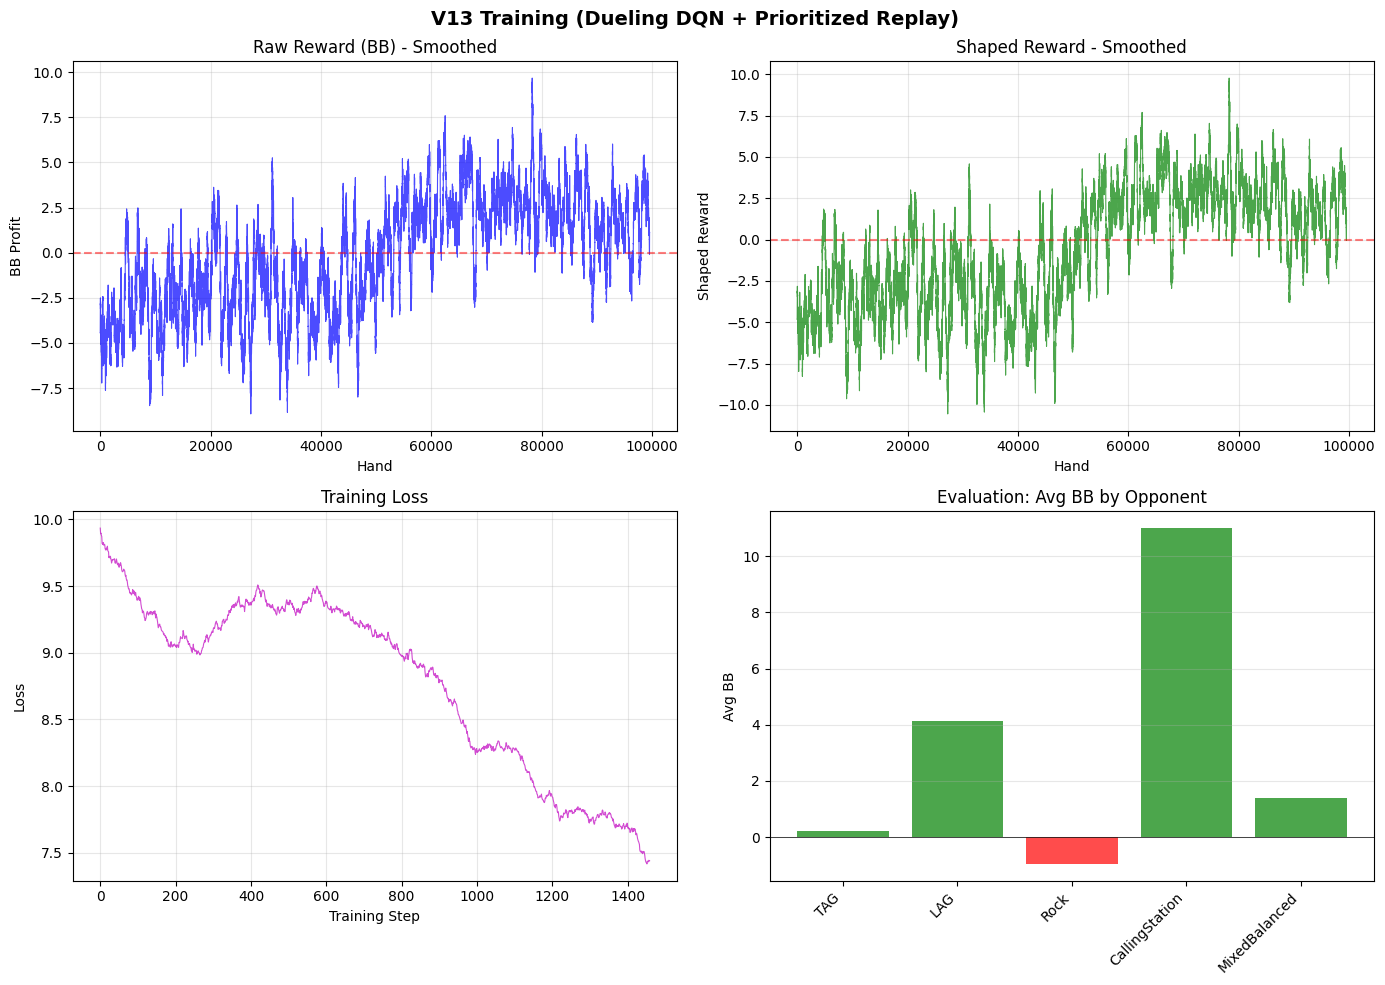


Training curves saved to v13_training_curves.png


In [9]:
# ============================================
# Training Curves (V11/V12 Style)
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('V13 Training (Dueling DQN + Prioritized Replay)', fontsize=14, fontweight='bold')

# Panel 1: Raw rewards
window = 500
if len(all_rewards) >= window:
    smoothed = np.convolve(all_rewards, np.ones(window)/window, mode='valid')
    axes[0,0].plot(smoothed, 'b-', alpha=0.7, linewidth=0.8)
    axes[0,0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0,0].set_title('Raw Reward (BB) - Smoothed')
axes[0,0].set_xlabel('Hand')
axes[0,0].set_ylabel('BB Profit')
axes[0,0].grid(True, alpha=0.3)

# Panel 2: Shaped rewards
if len(all_shaped) >= window:
    smoothed_s = np.convolve(all_shaped, np.ones(window)/window, mode='valid')
    axes[0,1].plot(smoothed_s, 'g-', alpha=0.7, linewidth=0.8)
    axes[0,1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0,1].set_title('Shaped Reward - Smoothed')
axes[0,1].set_xlabel('Hand')
axes[0,1].set_ylabel('Shaped Reward')
axes[0,1].grid(True, alpha=0.3)

# Panel 3: Loss
if len(loss_history) > 100:
    loss_smooth = np.convolve(loss_history, np.ones(100)/100, mode='valid')
    axes[1,0].plot(loss_smooth, 'm-', alpha=0.7, linewidth=0.8)
axes[1,0].set_title('Training Loss')
axes[1,0].set_xlabel('Training Step')
axes[1,0].set_ylabel('Loss')
axes[1,0].grid(True, alpha=0.3)

# Panel 4: Per-opponent final performance
if eval_results:
    opps = list(eval_results.keys())
    avgs = [eval_results[o]['avg'] for o in opps]
    colors = ['green' if a > 0 else 'red' for a in avgs]
    bars = axes[1,1].bar(range(len(opps)), avgs, color=colors, alpha=0.7)
    axes[1,1].set_xticks(range(len(opps)))
    axes[1,1].set_xticklabels(opps, rotation=45, ha='right')
    axes[1,1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[1,1].set_title('Evaluation: Avg BB by Opponent')
    axes[1,1].set_ylabel('Avg BB')
axes[1,1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('v13_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTraining curves saved to v13_training_curves.png")

In [10]:
# ============================================
# Save Model
# ============================================

torch.save({
    'model_state_dict': agent.model.state_dict(),
    'target_model_state_dict': agent.target_model.state_dict(),
    'optimizer_state_dict': agent.optimizer.state_dict(),
    'epsilon': agent.epsilon,
    'eval_results': eval_results,
}, 'poker_agent_v13.pth')

print(f"Model saved to poker_agent_v13.pth")
print(f"Final epsilon: {agent.epsilon:.4f}")

Model saved to poker_agent_v13.pth
Final epsilon: 0.0500
